## Unsupervised Learning - SOM

In [1]:
from math import sqrt

from numpy import (array, unravel_index, nditer, linalg, random, subtract,
                   power, exp, pi, zeros, arange, outer, meshgrid, dot)
from collections import defaultdict
from warnings import warn

# for unit tests
from numpy.testing import assert_almost_equal, assert_array_almost_equal
from numpy.testing import assert_array_equal
import unittest

"""
    Minimalistic implementation of the Self Organizing Maps (SOM).
"""


def fast_norm(x):
    """Returns norm-2 of a 1-D numpy array.
    * faster than linalg.norm in case of 1-D arrays (numpy 1.9.2rc1).
    """
    return sqrt(dot(x, x.T))


class MiniSom(object):
    def __init__(self, x, y, input_len, sigma=1.0, learning_rate=0.5,
                 decay_function=None, neighborhood_function='gaussian',
                 random_seed=None):
        """Initializes a Self Organizing Maps.
        Parameters
        ----------
        decision_tree : decision tree
        The decision tree to be exported.
        x : int
            x dimension of the SOM
        y : int
            y dimension of the SOM
        input_len : int
            Number of the elements of the vectors in input.
        sigma : float, optional (default=1.0)
            Spread of the neighborhood function, needs to be adequate
            to the dimensions of the map.
            (at the iteration t we have sigma(t) = sigma / (1 + t/T)
            where T is #num_iteration/2)
            learning_rate, initial learning rate
            (at the iteration t we have
            learning_rate(t) = learning_rate / (1 + t/T)
            where T is #num_iteration/2)
        decay_function : function (default=None)
            Function that reduces learning_rate and sigma at each iteration
            default function:
            lambda x, current_iteration, max_iter :
                        x/(1+current_iteration/max_iter)
        neighborhood_function : function, optional (default='gaussian')
            Function that weights the neighborhood of a position in the map
            possible values: 'gaussian', 'mexican_hat'
        random_seed : int, optiona (default=None)
            Random seed to use.
        """
        if sigma >= x/2.0 or sigma >= y/2.0:
            warn('Warning: sigma is too high for the dimension of the map.')
        if random_seed:
            self._random_generator = random.RandomState(random_seed)
        else:
            self._random_generator = random.RandomState(random_seed)
        if decay_function:
            self._decay_function = decay_function
        else:
            self._decay_function = lambda x, t, max_iter: x/(1+t/max_iter)
        self._learning_rate = learning_rate
        self._sigma = sigma
        # random initialization
        self._weights = self._random_generator.rand(x, y, input_len)*2-1
        for i in range(x):
            for j in range(y):
                # normalization
                norm = fast_norm(self._weights[i, j])
                self._weights[i, j] = self._weights[i, j] / norm
        self._activation_map = zeros((x, y))
        self._neigx = arange(x)
        self._neigy = arange(y)  # used to evaluate the neighborhood function
        neig_functions = {'gaussian': self._gaussian,
                          'mexican_hat': self._mexican_hat}
        if neighborhood_function not in neig_functions:
            msg = '%s not supported. Functions available: %s'
            raise ValueError(msg % (neighborhood_function,
                                    ', '.join(neig_functions.keys())))
        self.neighborhood = neig_functions[neighborhood_function]

    def get_weights(self):
        """Returns the weights of the neural network"""
        return self._weights

    def _activate(self, x):
        """Updates matrix activation_map, in this matrix
           the element i,j is the response of the neuron i,j to x"""
        s = subtract(x, self._weights)  # x - w
        it = nditer(self._activation_map, flags=['multi_index'])
        while not it.finished:
            # || x - w ||
            self._activation_map[it.multi_index] = fast_norm(s[it.multi_index])
            it.iternext()

    def activate(self, x):
        """Returns the activation map to x"""
        self._activate(x)
        return self._activation_map

    def _gaussian(self, c, sigma):
        """Returns a Gaussian centered in c"""
        d = 2*pi*sigma*sigma
        ax = exp(-power(self._neigx-c[0], 2)/d)
        ay = exp(-power(self._neigy-c[1], 2)/d)
        return outer(ax, ay)  # the external product gives a matrix

    def _mexican_hat(self, c, sigma):
        """Mexican hat centered in c"""
        xx, yy = meshgrid(self._neigx, self._neigy)
        p = power(xx-c[0], 2) + power(yy-c[1], 2)
        d = 2*pi*sigma*sigma
        return exp(-p/d)*(1-2/d*p)

    def winner(self, x):
        """Computes the coordinates of the winning neuron for the sample x"""
        self._activate(x)
        return unravel_index(self._activation_map.argmin(),
                             self._activation_map.shape)

    def update(self, x, win, t):
        """Updates the weights of the neurons.
        Parameters
        ----------
        x : np.array
            Current pattern to learn
        win : tuple
            Position of the winning neuron for x (array or tuple).
        t : int
            Iteration index
        """
        eta = self._decay_function(self._learning_rate, t, self.T)
        # sigma and learning rate decrease with the same rule
        sig = self._decay_function(self._sigma, t, self.T)
        # improves the performances
        g = self.neighborhood(win, sig)*eta
        it = nditer(g, flags=['multi_index'])
        while not it.finished:
            # eta * neighborhood_function * (x-w)
            x_w = (x - self._weights[it.multi_index])
            self._weights[it.multi_index] += g[it.multi_index] * x_w
            # normalization
            norm = fast_norm(self._weights[it.multi_index])
            self._weights[it.multi_index] = self._weights[it.multi_index]/norm
            it.iternext()

    def quantization(self, data):
        """Assigns a code book (weights vector of the winning neuron)
        to each sample in data."""
        q = zeros(data.shape)
        for i, x in enumerate(data):
            q[i] = self._weights[self.winner(x)]
        return q

    def random_weights_init(self, data):
        """Initializes the weights of the SOM
        picking random samples from data"""
        it = nditer(self._activation_map, flags=['multi_index'])
        while not it.finished:
            rand_i = self._random_generator.randint(len(data))
            self._weights[it.multi_index] = data[rand_i]
            norm = fast_norm(self._weights[it.multi_index])
            self._weights[it.multi_index] = self._weights[it.multi_index]/norm
            it.iternext()

    def train_random(self, data, num_iteration):
        """Trains the SOM picking samples at random from data"""
        self._init_T(num_iteration)
        for iteration in range(num_iteration):
            # pick a random sample
            rand_i = self._random_generator.randint(len(data))
            self.update(data[rand_i], self.winner(data[rand_i]), iteration)

    def train_batch(self, data, num_iteration):
        """Trains using all the vectors in data sequentially"""
        self._init_T(len(data)*num_iteration)
        iteration = 0
        while iteration < num_iteration:
            idx = iteration % (len(data)-1)
            self.update(data[idx], self.winner(data[idx]), iteration)
            iteration += 1

    def _init_T(self, num_iteration):
        """Initializes the parameter T needed to adjust the learning rate"""
        # keeps the learning rate nearly constant
        # for the last half of the iterations
        self.T = num_iteration/2

    def distance_map(self):
        """Returns the distance map of the weights.
        Each cell is the normalised sum of the distances between
        a neuron and its neighbours."""
        um = zeros((self._weights.shape[0], self._weights.shape[1]))
        it = nditer(um, flags=['multi_index'])
        while not it.finished:
            for ii in range(it.multi_index[0]-1, it.multi_index[0]+2):
                for jj in range(it.multi_index[1]-1, it.multi_index[1]+2):
                    if (ii >= 0 and ii < self._weights.shape[0] and
                            jj >= 0 and jj < self._weights.shape[1]):
                        w_1 = self._weights[ii, jj, :]
                        w_2 = self._weights[it.multi_index]
                        um[it.multi_index] += fast_norm(w_1-w_2)
            it.iternext()
        um = um/um.max()
        return um

    def activation_response(self, data):
        """
            Returns a matrix where the element i,j is the number of times
            that the neuron i,j have been winner.
        """
        a = zeros((self._weights.shape[0], self._weights.shape[1]))
        for x in data:
            a[self.winner(x)] += 1
        return a

    def quantization_error(self, data):
        """Returns the quantization error computed as the average
        distance between each input sample and its best matching unit."""
        error = 0
        for x in data:
            error += fast_norm(x-self._weights[self.winner(x)])
        return error/len(data)

    def win_map(self, data):
        """Returns a dictionary wm where wm[(i,j)] is a list
        with all the patterns that have been mapped in the position i,j."""
        winmap = defaultdict(list)
        for x in data:
            winmap[self.winner(x)].append(x)
        return winmap


class TestMinisom(unittest.TestCase):
    def setup_method(self, method):
        self.som = MiniSom(5, 5, 1)
        for i in range(5):
            for j in range(5):
                # checking weights normalization
                assert_almost_equal(1.0, linalg.norm(self.som._weights[i, j]))
        self.som._weights = zeros((5, 5))  # fake weights
        self.som._weights[2, 3] = 5.0
        self.som._weights[1, 1] = 2.0

    def test_decay_function(self):
        assert self.som._decay_function(1., 2., 3.) == 1./(1.+2./3.)

    def test_fast_norm(self):
        assert fast_norm(array([1, 3])) == sqrt(1+9)

    def test_unavailable_neigh_function(self):
        with self.assertRaises(ValueError):
            MiniSom(5, 5, 1, neighborhood_function='boooom')

    def test_gaussian(self):
        bell = self.som._gaussian((2, 2), 1)
        assert bell.max() == 1.0
        assert bell.argmax() == 12  # unravel(12) = (2,2)

    def test_win_map(self):
        winners = self.som.win_map([5.0, 2.0])
        assert winners[(2, 3)][0] == 5.0
        assert winners[(1, 1)][0] == 2.0

    def test_activation_reponse(self):
        response = self.som.activation_response([5.0, 2.0])
        assert response[2, 3] == 1
        assert response[1, 1] == 1

    def test_activate(self):
        assert self.som.activate(5.0).argmin() == 13.0  # unravel(13) = (2,3)

    def test_quantization_error(self):
        self.som.quantization_error([5, 2]) == 0.0
        self.som.quantization_error([4, 1]) == 0.5

    def test_quantization(self):
        q = self.som.quantization(array([4, 2]))
        assert q[0] == 5.0
        assert q[1] == 2.0

    def test_random_seed(self):
        som1 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        som2 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        # same initialization
        assert_array_almost_equal(som1._weights, som2._weights)
        data = random.rand(100, 2)
        som1 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        som1.train_random(data, 10)
        som2 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        som2.train_random(data, 10)
        # same state after training
        assert_array_almost_equal(som1._weights, som2._weights)

    def test_train_batch(self):
        som = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        data = array([[4, 2], [3, 1]])
        q1 = som.quantization_error(data)
        som.train_batch(data, 10)
        assert q1 > som.quantization_error(data)

    def test_train_random(self):
        som = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        data = array([[4, 2], [3, 1]])
        q1 = som.quantization_error(data)
        som.train_random(data, 10)
        assert q1 > som.quantization_error(data)

    def test_random_weights_init(self):
        som = MiniSom(2, 2, 2, random_seed=1)
        som.random_weights_init(array([[1.0, .0]]))
        for w in som._weights:
            assert_array_equal(w[0], array([1.0, .0]))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Training...

...ready!


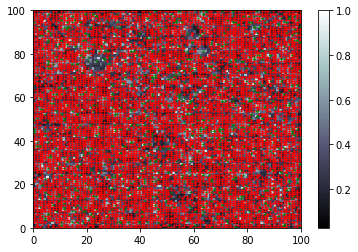

In [4]:
import pandas

features = [
    "mean_of_the_integrated_profile",
    "standard_deviation_of_the_integrated_profile",
    "excess_kurtosis_of_the_integrated_profile",
    "skewness_of_the_integrated_profile",
    "mean_of_the_DM_SNR_curve",
    "standard_deviation_of_the_DM_SNR_curve",
    "excess_kurtosis_of_the_DM_SNR_curve",
    "skewness_of_the_DM_SNR_curve",
    "star_class"
]

all_data = pandas.read_csv('HTRU_2.csv', sep=",", names=features)


f1 = all_data.mean_of_the_integrated_profile
f2 = all_data.standard_deviation_of_the_integrated_profile
f3 = all_data.excess_kurtosis_of_the_integrated_profile
f4 = all_data.skewness_of_the_integrated_profile
f5 = all_data.mean_of_the_DM_SNR_curve
f6 = all_data.standard_deviation_of_the_DM_SNR_curve
f7 = all_data.excess_kurtosis_of_the_DM_SNR_curve
f8 = all_data.skewness_of_the_DM_SNR_curve

target = all_data.star_class
data = np.column_stack((f1,f2,f3,f4,f5,f6,f7,f8))
#data = data[1:1000,:]

# Normalizing Data
data = np.apply_along_axis(lambda x: x/np.linalg.norm(x), 1, data)


# Initialization and training
som = MiniSom(100, 100, 8, sigma=1.0, learning_rate=0.5)
som.random_weights_init(data)
print("Training...")
som.train_random(data, 100)  # random training
print("\n...ready!")


plt.bone()
plt.pcolor(som.distance_map().T)  # plotting the distance map as background
plt.colorbar()

# use different colors and markers for each label
markers = ['o', 'o']
colors = ['r', 'g']

mapped_data_to_som = []

for cnt, xx in enumerate(data):
    
    w = som.winner(xx)  # getting the winner

    # Saving som Result
    som_result = []
    som_result.append(w[0])
    som_result.append(w[1])
    som_result.append(target[cnt])
    mapped_data_to_som.append(som_result)
    
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[target[cnt]], markerfacecolor='None',
             markeredgecolor=colors[target[cnt]], markersize=1, markeredgewidth=1)
plt.axis([0, 100, 0, 100])
plt.show()

In [ ]:
#print(mapped_data_to_som)

## KNN Classification

Usando outro algoritmo que classifica considerando os pontos mais próximos. Utilizado para comparar a perda de informações ao utilizar o mapa de Kohonen.

### No espaço original

In [7]:
import pandas

features = [
    "mean_of_the_integrated_profile",
    "standard_deviation_of_the_integrated_profile",
    "excess_kurtosis_of_the_integrated_profile",
    "skewness_of_the_integrated_profile",
    "mean_of_the_DM_SNR_curve",
    "standard_deviation_of_the_DM_SNR_curve",
    "excess_kurtosis_of_the_DM_SNR_curve",
    "skewness_of_the_DM_SNR_curve",
    "star_class"
]

all_data = pandas.read_csv('HTRU_2.csv', sep=",", names=features)


f1 = all_data.mean_of_the_integrated_profile
f2 = all_data.standard_deviation_of_the_integrated_profile
f3 = all_data.excess_kurtosis_of_the_integrated_profile
f4 = all_data.skewness_of_the_integrated_profile
f5 = all_data.mean_of_the_DM_SNR_curve
f6 = all_data.standard_deviation_of_the_DM_SNR_curve
f7 = all_data.excess_kurtosis_of_the_DM_SNR_curve
f8 = all_data.skewness_of_the_DM_SNR_curve

data = np.column_stack((f1,f2,f3,f4,f5,f6,f7,f8))
target = all_data.star_class

# Normalizing Data
data = np.apply_along_axis(lambda x: x/np.linalg.norm(x), 1, data)


from sklearn.cross_validation import cross_val_score
cross_val_k = 10

from sklearn.neighbors import KNeighborsClassifier


k_range = range(1,15)
cnt = 0
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, data, target, cv=cross_val_k, scoring='accuracy')
    cnt = cnt + 1
    print(cnt, scores.mean())


1 0.96055378501
2 0.969214002725
3 0.971728656593
4 0.972454788597
5 0.972846287478
6 0.97256664542
7 0.97290202842
8 0.972901653481
9 0.972957706873
10 0.972901778461
11 0.972622636322
12 0.972287128342
13 0.972957769362
14 0.972454913577


### No espaço 2D da Self Organizing Map

In [6]:
from sklearn.cross_validation import cross_val_score
cross_val_k = 10

from sklearn.neighbors import KNeighborsClassifier

data = np.array(mapped_data_to_som)[:,0:1]
target = np.array(mapped_data_to_som)[:,2]
#print(data)

k_range = range(1,15)
cnt = 0
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, data, target, cv=cross_val_k, scoring='accuracy')
    cnt = cnt + 1
    print(cnt, scores.mean())

1 0.842773861747
2 0.905128416632
3 0.892613262845
4 0.906917188457
5 0.902111531876
6 0.906414395161
7 0.903285903541
8 0.9070289203
9 0.904850149351
10 0.908034506893
11 0.908034506893
12 0.908034506893
13 0.908034506893
14 0.908425568345
